⚠ No GPU found, using CPU
Loading dataset...
Found 3662 out of 3662 images
Dataset shape: (3662, 6)
4-Class distribution:
  0 (No DR): 1805 images
  1 (Moderate DR): 1369 images
  2 (Severe DR): 193 images
  3 (Proliferative DR): 295 images
Train: 2197, Validation: 732, Test: 733
Generating retina masks...


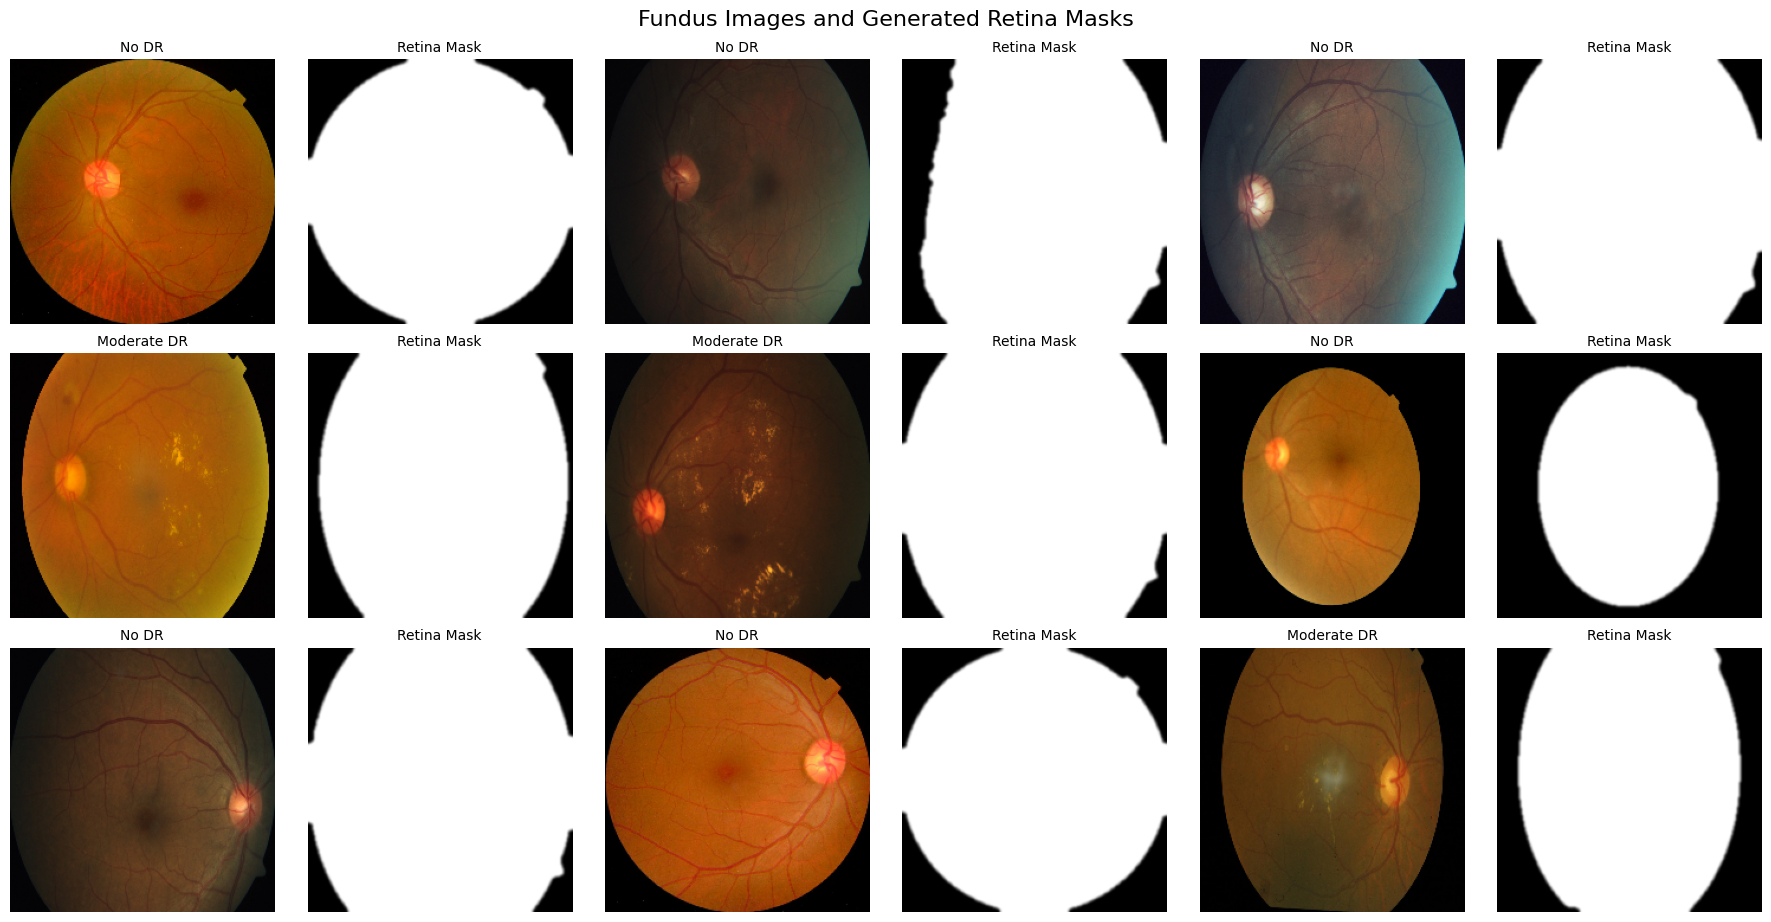

Creating optimized datasets with retina masks...
RETINA-FOCUSED DIABETIC RETINOPATHY CLASSIFICATION (4-CLASS)
Creating DenseNet model with retina masking...
Feature maps shape after base model: (None, 7, 7, 1024)
Masked features shape: (None, 7, 7, 1024)

Model Parameters:
Total params: 7,301,957

Phase 1: Training with frozen base model for 15 epochs...
Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.3987 - loss: 1.3611
Epoch 1: val_loss improved from inf to 0.82388, saving model to best_retina_model_phase1.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.4007 - loss: 1.3580 - val_accuracy: 0.7555 - val_loss: 0.8239 - learning_rate: 1.0000e-04
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.7116 - loss: 0.8734
Epoch 2: val_loss improved from 0.82388 to 0.65465, saving model to best_retina_model_phase1.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7119 - loss: 0.8725 - val_accuracy: 0.7787 - val_loss: 0.6546 - learning_rate: 1.



DenseNet + Retina Mask (Fine-tuned) Results (4-Class Classification):
------------------------------------------------------------
Overall Accuracy: 0.8622

Detailed Classification Report:
                  precision    recall  f1-score   support

           No DR     0.9697    0.9751    0.9724       361
     Moderate DR     0.8084    0.9088    0.8557       274
       Severe DR     0.5000    0.2308    0.3158        39
Proliferative DR     0.5000    0.3729    0.4272        59

        accuracy                         0.8622       733
       macro avg     0.6945    0.6219    0.6428       733
    weighted avg     0.8466    0.8622    0.8499       733


Confusion Matrix:
Predicted ->
True |
     v
               0           1           2           3
 0:          352           9           0           0
 1:           11         249           4          10
 2:            0          18           9          12
 3:            0          32           5          22

Saving final model to: retina_

In [ ]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, cohen_kappa_score,
    precision_recall_curve, roc_curve, classification_report
)
import time
import psutil
from tensorflow.keras.applications import DenseNet121

tf.random.set_seed(7)

# GPU Configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ Found {len(gpus)} GPU(s)")
        print(f"✓ GPU devices: {[gpu.name for gpu in gpus]}")
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print("✓ Mixed precision enabled")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("⚠ No GPU found, using CPU")

# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15

# Custom Feature Masking Layer
class RetinaMaskLayer(tf.keras.layers.Layer):
    """Custom layer that applies retina mask to feature maps"""
    
    def __init__(self, **kwargs):
        super(RetinaMaskLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(RetinaMaskLayer, self).build(input_shape)
    
    def call(self, inputs):
        feature_maps, mask = inputs
        
        # Get feature map dimensions
        feature_shape = tf.shape(feature_maps)
        batch_size = feature_shape[0]
        height = feature_shape[1] 
        width = feature_shape[2]
        channels = feature_shape[3]
        
        # Remove extra dimension from mask if present and resize
        if len(mask.shape) == 5:  # [batch, height, width, 1, 1]
            mask = tf.squeeze(mask, axis=[-1, -2])
        elif len(mask.shape) == 4 and mask.shape[-1] == 1:  # [batch, height, width, 1]
            mask = tf.squeeze(mask, axis=-1)
        
        # Resize mask to match feature map spatial dimensions
        mask_resized = tf.image.resize(
            tf.expand_dims(mask, axis=-1), 
            [height, width], 
            method='bilinear'
        )
        
        # Broadcast mask to match all channels
        mask_broadcasted = tf.broadcast_to(mask_resized, [batch_size, height, width, channels])
        
        # Apply mask to feature maps
        masked_features = feature_maps * mask_broadcasted
        
        return masked_features
    
    def get_config(self):
        config = super(RetinaMaskLayer, self).get_config()
        return config

def create_retina_mask(image_array):
    """
    Create binary mask for retina region in fundus image
    Args:
        image_array: TensorFlow tensor of shape (height, width, 3)
    Returns:
        mask: binary mask where 1=retina, 0=background
    """
    # Convert TensorFlow tensor to numpy
    if hasattr(image_array, 'numpy'):
        image_np = image_array.numpy()
    else:
        image_np = np.array(image_array)
    
    # Ensure we have the right data type
    image_np = image_np.astype(np.uint8)
    
    # Convert to grayscale
    if len(image_np.shape) == 3 and image_np.shape[-1] == 3:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_np.astype(np.uint8)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Threshold to separate retina from black background
    # Most fundus images have black background (pixel value ~0-20)
    _, binary_mask = cv2.threshold(blurred, 20, 255, cv2.THRESH_BINARY)
    
    # Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    
    # Find the largest contour (assumed to be the retina)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Create a clean mask from the largest contour
        mask = np.zeros_like(binary_mask)
        cv2.fillPoly(mask, [largest_contour], 255)
        
        # Apply Gaussian blur to create smooth edges
        mask = cv2.GaussianBlur(mask, (5, 5), 0)
        
        # Normalize to 0-1 range
        mask = mask.astype(np.float32) / 255.0
    else:
        # If no contours found, create a circular mask in center
        h, w = gray.shape
        center = (w//2, h//2)
        radius = min(h, w) // 3
        mask = np.zeros((h, w), dtype=np.float32)
        cv2.circle(mask, center, radius, 1.0, -1)
    
    return mask.astype(np.float32)

def create_retina_mask_tf(image_tensor):
    """
    TensorFlow-compatible wrapper for create_retina_mask
    """
    def py_create_mask(img):
        return create_retina_mask(img)
    
    # Use tf.numpy_function instead of tf.py_function for better compatibility
    mask = tf.numpy_function(
        func=py_create_mask,
        inp=[image_tensor],
        Tout=tf.float32
    )
    
    # Set shape explicitly
    mask.set_shape([IMG_SIZE, IMG_SIZE])
    
    return mask

# Modified data loading function with mask generation
def create_tf_dataset_with_masks(dataframe, batch_size, shuffle=False):
    """Create TensorFlow dataset with retina masks"""
    
    def load_and_preprocess_with_mask(path, label):
        # Load image
        image_raw = tf.io.read_file(path)
        image_decoded = tf.image.decode_png(image_raw, channels=3)
        image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
        image_float = tf.cast(image_resized, tf.float32)
        
        # Preprocessing for DenseNet
        image_preprocessed = tf.keras.applications.densenet.preprocess_input(image_float)
        
        # Generate mask using the TensorFlow-compatible wrapper
        mask = create_retina_mask_tf(image_resized)
        
        # Ensure mask has correct shape [height, width, 1]
        mask = tf.expand_dims(mask, axis=-1)
        
        return {'image': image_preprocessed, 'mask': mask}, label
    
    # Create dataset from paths
    paths = tf.constant(dataframe['filepath'].values)
    labels = tf.constant(dataframe['label'].values)
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_and_preprocess_with_mask, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(1000, seed=42)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def create_retina_focused_densenet():
    """Create DenseNet model with retina-focused feature masking"""
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    
    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        # Input layers
        image_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image')
        mask_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='mask')
        
        # Base DenseNet121 model
        base_model = DenseNet121(
            weights="imagenet", 
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
        base_model.trainable = False
        
        # Get feature maps from base model
        feature_maps = base_model(image_input, training=False)
        print(f"Feature maps shape after base model: {feature_maps.shape}")
        
        # Apply retina mask to feature maps
        masked_features = RetinaMaskLayer()([feature_maps, mask_input])
        print(f"Masked features shape: {masked_features.shape}")
        
        # Add attention mechanism to focus on important regions
        attention = tf.keras.layers.Conv2D(
            1, (1, 1), 
            activation='sigmoid', 
            dtype='float32', 
            name='attention'
        )(masked_features)
        
        # Apply attention weights
        attended_features = tf.keras.layers.Multiply()([masked_features, attention])
        
        # Global pooling and classification head
        x = tf.keras.layers.GlobalAveragePooling2D()(attended_features)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(256, activation="relu", dtype='float32')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        
        # Output layer for 4 classes (0: No DR, 1: Moderate DR, 2: Severe DR, 3: Proliferative DR)
        outputs = tf.keras.layers.Dense(4, activation="softmax", dtype='float32', name='predictions')(x)
        
        # Create model
        model = tf.keras.Model(inputs=[image_input, mask_input], outputs=outputs)
    
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )
    
    return model, base_model

# Local paths - adjust these to your actual paths
BASE_DIR = r"C:\Users\nande\OneDrive\Desktop\Diabetic_Retinopathy\DataBase"
train_csv_path = os.path.join(BASE_DIR, "train.csv")
images_base_dir = os.path.join(BASE_DIR, "colored_images")

# Load and prepare data with 4-class mapping
print("Loading dataset...")
df = pd.read_csv(train_csv_path)

# Map original 5 classes to 4 classes
# 0: No DR -> 0: No DR
# 1: Mild DR -> 1: Moderate DR (combined with Moderate)
# 2: Moderate DR -> 1: Moderate DR (combined with Mild)
# 3: Severe DR -> 2: Severe DR
# 4: Proliferative DR -> 3: Proliferative DR

def map_to_4_classes(diagnosis):
    if diagnosis == 0:
        return 0  # No DR
    elif diagnosis in [1, 2]:
        return 1  # Moderate DR (combining Mild and Moderate)
    elif diagnosis == 3:
        return 2  # Severe DR
    elif diagnosis == 4:
        return 3  # Proliferative DR
    else:
        return diagnosis

df["label"] = df["diagnosis"].apply(map_to_4_classes)

# Map diagnosis levels to folder names and new class names
diagnosis_to_folder = {
    0: "No_DR",
    1: "Mild", 
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# New 4-class mapping
class_names_4 = {
    0: "No DR",
    1: "Moderate DR", 
    2: "Severe DR",
    3: "Proliferative DR"
}

df["folder"] = df["diagnosis"].map(diagnosis_to_folder)
df["class_name"] = df["label"].map(class_names_4)
df["filepath"] = df.apply(lambda row: os.path.join(images_base_dir, row["folder"], f"{row['id_code']}.png"), axis=1)

# Verify files exist
existing_files = df["filepath"].apply(os.path.exists)
print(f"Found {existing_files.sum()} out of {len(df)} images")
df = df[existing_files].reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"4-Class distribution:")
for level in sorted(df['label'].unique()):
    count = (df['label'] == level).sum()
    class_name = class_names_4[level]
    print(f"  {level} ({class_name}): {count} images")

# Train-validation-test split
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# Visualization function for masks
def visualize_retina_masks(dataframe, n_samples=9):
    """Visualize original images with their retina masks"""
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    
    sample_df = dataframe.sample(n_samples, random_state=42)
    
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        row_idx = idx // 3
        col_idx = (idx % 3) * 2
        
        # Load and preprocess image
        img_path = row['filepath']
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Create mask
            mask = create_retina_mask(img_rgb)
            
            # Display original image
            axes[row_idx, col_idx].imshow(img_rgb)
            axes[row_idx, col_idx].set_title(f'{row["class_name"]}', fontsize=10)
            axes[row_idx, col_idx].axis('off')
            
            # Display mask
            axes[row_idx, col_idx + 1].imshow(mask, cmap='gray')
            axes[row_idx, col_idx + 1].set_title('Retina Mask', fontsize=10)
            axes[row_idx, col_idx + 1].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Fundus Images and Generated Retina Masks', fontsize=16, y=1.02)
    plt.show()

# Visualize masks
print("Generating retina masks...")
visualize_retina_masks(train_df)

# Create datasets with masks
print("Creating optimized datasets with retina masks...")
train_set = create_tf_dataset_with_masks(train_df, BATCH_SIZE, shuffle=True)
valid_set = create_tf_dataset_with_masks(val_df, BATCH_SIZE)
test_set = create_tf_dataset_with_masks(test_df, BATCH_SIZE)

def evaluate_model_4_class(model, test_set, model_name="Model"):
    """Evaluation function for 4-class classification"""
    print(f"\nEvaluating {model_name}...")
    
    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        y_true, y_pred_probs = [], []
        
        for batch_num, (batch_data, labels) in enumerate(test_set):
            print(f"\rEvaluating batch {batch_num + 1}", end='')
            y_true.extend(labels.numpy())
            predictions = model.predict(batch_data, verbose=0)
            y_pred_probs.extend(predictions)
    
    print()  # New line
    
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    class_names = ['No DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
    
    print(f"\n{model_name} Results (4-Class Classification):")
    print("-" * 60)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print("Predicted ->")
    print("True |")
    print("     v")
    
    header = "    " + "".join([f"{i:>12}" for i in range(4)])
    print(header)
    for i, row in enumerate(conf_matrix):
        row_str = f"{i:>2}: " + "".join([f"{val:>12}" for val in row])
        print(row_str)
    
    return {
        'overall_accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs
    }

def predict_single_image_with_mask(model, img_path, img_size=(224, 224)):
    """Predict single image with retina mask"""
    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create mask using the numpy version
    mask = create_retina_mask(img_rgb)
    
    # Preprocess for model
    img_array = tf.keras.applications.densenet.preprocess_input(img_rgb.astype(np.float32))
    img_array = np.expand_dims(img_array, axis=0)
    mask_array = np.expand_dims(np.expand_dims(mask, axis=-1), axis=0)
    
    # Predict
    pred = model.predict({'image': img_array, 'mask': mask_array}, verbose=0)
    pred_class = pred.argmax(axis=1)[0]
    confidence = pred.max(axis=1)[0]
    
    class_names = {0: "No DR", 1: "Moderate DR", 2: "Severe DR", 3: "Proliferative DR"}
    
    print(f"Prediction: {class_names[pred_class]}")
    print(f"Confidence: {confidence:.4f}")
    print(f"All probabilities: {pred[0]}")
    
    # Visualize the image and mask
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Generated Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    masked_img = img_rgb * np.expand_dims(mask, axis=-1)
    plt.imshow(masked_img.astype(np.uint8))
    plt.title(f'Prediction: {class_names[pred_class]} ({confidence:.3f})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return pred_class, confidence, pred[0]

# Main training and evaluation
if __name__ == "__main__":
    print("="*60)
    print("RETINA-FOCUSED DIABETIC RETINOPATHY CLASSIFICATION (4-CLASS)")
    print("="*60)
    
    # Create model
    print("Creating DenseNet model with retina masking...")
    model, base_model = create_retina_focused_densenet()
    
    print(f"\nModel Parameters:")
    print(f"Total params: {model.count_params():,}")
    
    # Training phase 1: Frozen base model
    print(f"\nPhase 1: Training with frozen base model for {EPOCHS} epochs...")
    
    callbacks_list = [
        tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(
            'best_retina_model_phase1.keras', 
            save_best_only=True, 
            verbose=1
        )
    ]
    
    start_time = time.time()
    
    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        history1 = model.fit(
            train_set,
            validation_data=valid_set,
            epochs=EPOCHS,
            callbacks=callbacks_list,
            verbose=1
        )
    
    phase1_time = time.time() - start_time
    print(f"Phase 1 training time: {phase1_time:.2f} seconds")
    
    # Evaluate frozen model
    results1 = evaluate_model_4_class(model, test_set, "DenseNet + Retina Mask (Frozen)")
    
    # Training phase 2: Fine-tuning
    print(f"\nPhase 2: Fine-tuning last 25% of base model layers...")
    
    # Unfreeze last 25% of layers
    base_model.trainable = True
    n_layers = len(base_model.layers)
    freeze_layers = int(0.75 * n_layers)
    
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    unfrozen_layers = n_layers - freeze_layers
    print(f"Unfroze {unfrozen_layers} out of {n_layers} base model layers")
    
    # Recompile with lower learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )
    
    callbacks_list = [
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=4, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(
            'best_retina_model_final.keras', 
            save_best_only=True, 
            verbose=1
        )
    ]
    
    start_time = time.time()
    
    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        history2 = model.fit(
            train_set,
            validation_data=valid_set,
            epochs=EPOCHS,
            callbacks=callbacks_list,
            verbose=1
        )
    
    phase2_time = time.time() - start_time
    print(f"Phase 2 training time: {phase2_time:.2f} seconds")
    
    # Final evaluation
    results2 = evaluate_model_4_class(model, test_set, "DenseNet + Retina Mask (Fine-tuned)")
    
    # Save final model
    model_path = 'retina_focused_dr_classifier_4class.keras'
    print(f"\nSaving final model to: {model_path}")
    model.save(model_path, save_format='keras')
    print(f"✓ Model saved successfully!")
    
    # Training summary
    total_time = phase1_time + phase2_time
    print(f"\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Phase 1 time: {phase1_time:.2f} seconds")
    print(f"Phase 2 time: {phase2_time:.2f} seconds")
    print(f"Total training time: {total_time:.2f} seconds")
    print(f"Final model accuracy: {results2['overall_accuracy']:.4f}")
    print(f"Model saved as: {model_path}")
    
    print("\n✓ Training completed successfully!")
    
    # Example prediction
    print(f"\nTo use the trained model for prediction:")
    print(f"model = tf.keras.models.load_model('{model_path}', custom_objects={{'RetinaMaskLayer': RetinaMaskLayer}})")
    print("Then use: predict_single_image_with_mask(model, 'path_to_image.png')")



**Phase 1 (Frozen Base Model): Overall accuracy: 84.17%**

**Phase 2 (Fine-tuning last 25% of DenseNet): Overall accuracy improved to 86.22%**

In [ ]:
# model = tf.keras.models.load_model('retina_focused_dr_classifier_4class.keras', 
#                                    custom_objects={'RetinaMaskLayer': RetinaMaskLayer})



In [ ]:
# img_path = r"C:\Users\nande\OneDrive\Desktop\Diabetic_Retinopathy\output\c2_test.png"
# pred_class, confidence, probabilities = predict_single_image_with_mask(model, img_path)

In [1]:
import tensorflow as tf
print(tf.__version__)

2.16.1


In [ ]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, cohen_kappa_score,
    precision_recall_curve, roc_curve, classification_report
)
import time
import psutil
from tensorflow.keras.applications import DenseNet121

tf.random.set_seed(7)

# GPU Configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ Found {len(gpus)} GPU(s)")
        print(f"✓ GPU devices: {[gpu.name for gpu in gpus]}")
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print("✓ Mixed precision enabled")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("⚠ No GPU found, using CPU")

# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50

class RetinaMaskLayer(tf.keras.layers.Layer):
    """Custom layer that applies retina mask to feature maps"""
    
    def __init__(self, **kwargs):
        super(RetinaMaskLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(RetinaMaskLayer, self).build(input_shape)
    
    def call(self, inputs):
        feature_maps, mask = inputs
        
        # Get feature map dimensions
        feature_shape = tf.shape(feature_maps)
        batch_size = feature_shape[0]
        height = feature_shape[1] 
        width = feature_shape[2]
        channels = feature_shape[3]
        
        # Remove extra dimension from mask if present and resize
        if len(mask.shape) == 5:  # [batch, height, width, 1, 1]
            mask = tf.squeeze(mask, axis=[-1, -2])
        elif len(mask.shape) == 4 and mask.shape[-1] == 1:  # [batch, height, width, 1]
            mask = tf.squeeze(mask, axis=-1)
        
        # Resize mask to match feature map spatial dimensions
        mask_resized = tf.image.resize(
            tf.expand_dims(mask, axis=-1), 
            [height, width], 
            method='bilinear'
        )
        
        # Broadcast mask to match all channels
        mask_broadcasted = tf.broadcast_to(mask_resized, [batch_size, height, width, channels])
        
        # Apply mask to feature maps
        masked_features = feature_maps * mask_broadcasted
        
        return masked_features
    
    def get_config(self):
        config = super(RetinaMaskLayer, self).get_config()
        return config

def create_retina_mask(image_array):
    """
    Create binary mask for retina region in fundus image
    Args:
        image_array: TensorFlow tensor of shape (height, width, 3)
    Returns:
        mask: binary mask where 1=retina, 0=background
    """
    # Convert TensorFlow tensor to numpy
    if hasattr(image_array, 'numpy'):
        image_np = image_array.numpy()
    else:
        image_np = np.array(image_array)
    
    # Ensure we have the right data type
    image_np = image_np.astype(np.uint8)
    
    # Convert to grayscale
    if len(image_np.shape) == 3 and image_np.shape[-1] == 3:
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_np.astype(np.uint8)
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Threshold to separate retina from black background
    # Most fundus images have black background (pixel value ~0-20)
    _, binary_mask = cv2.threshold(blurred, 20, 255, cv2.THRESH_BINARY)
    
    # Morphological operations to clean up the mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    
    # Find the largest contour (assumed to be the retina)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Get the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        
        # Create a clean mask from the largest contour
        mask = np.zeros_like(binary_mask)
        cv2.fillPoly(mask, [largest_contour], 255)
        
        # Apply Gaussian blur to create smooth edges
        mask = cv2.GaussianBlur(mask, (5, 5), 0)
        
        # Normalize to 0-1 range
        mask = mask.astype(np.float32) / 255.0
    else:
        # If no contours found, create a circular mask in center
        h, w = gray.shape
        center = (w//2, h//2)
        radius = min(h, w) // 3
        mask = np.zeros((h, w), dtype=np.float32)
        cv2.circle(mask, center, radius, 1.0, -1)
    
    return mask.astype(np.float32)

def create_retina_mask_tf(image_tensor):
    """
    TensorFlow-compatible wrapper for create_retina_mask
    """
    def py_create_mask(img):
        return create_retina_mask(img)
    
    # Use tf.numpy_function instead of tf.py_function for better compatibility
    mask = tf.numpy_function(
        func=py_create_mask,
        inp=[image_tensor],
        Tout=tf.float32
    )
    
    # Set shape explicitly
    mask.set_shape([IMG_SIZE, IMG_SIZE])
    
    return mask

# Modified data loading function with mask generation
def create_tf_dataset_with_masks(dataframe, batch_size, shuffle=False):
    """Create TensorFlow dataset with retina masks"""
    
    def load_and_preprocess_with_mask(path, label):
        # Load image
        image_raw = tf.io.read_file(path)
        image_decoded = tf.image.decode_png(image_raw, channels=3)
        image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
        image_float = tf.cast(image_resized, tf.float32)
        
        # Preprocessing for DenseNet
        image_preprocessed = tf.keras.applications.densenet.preprocess_input(image_float)
        
        # Generate mask using the TensorFlow-compatible wrapper
        mask = create_retina_mask_tf(image_resized)
        
        # Ensure mask has correct shape [height, width, 1]
        mask = tf.expand_dims(mask, axis=-1)
        
        return {'image': image_preprocessed, 'mask': mask}, label
    
    # Create dataset from paths
    paths = tf.constant(dataframe['filepath'].values)
    labels = tf.constant(dataframe['label'].values)
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_and_preprocess_with_mask, num_parallel_calls=tf.data.AUTOTUNE)
    
    if shuffle:
        dataset = dataset.shuffle(1000, seed=42)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def create_retina_focused_densenet():
    """Create DenseNet model with retina-focused feature masking for 5-class classification"""
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    
    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        # Input layers
        image_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image')
        mask_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='mask')
        
        # Base DenseNet121 model
        base_model = DenseNet121(
            weights="imagenet", 
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
        base_model.trainable = False
        
        # Get feature maps from base model
        feature_maps = base_model(image_input, training=False)
        print(f"Feature maps shape after base model: {feature_maps.shape}")
        
        # Apply retina mask to feature maps
        masked_features = RetinaMaskLayer()([feature_maps, mask_input])
        print(f"Masked features shape: {masked_features.shape}")
        
        # Add attention mechanism to focus on important regions
        attention = tf.keras.layers.Conv2D(
            1, (1, 1), 
            activation='sigmoid', 
            dtype='float32', 
            name='attention'
        )(masked_features)
        
        # Apply attention weights
        attended_features = tf.keras.layers.Multiply()([masked_features, attention])
        
        # Global pooling and classification head
        x = tf.keras.layers.GlobalAveragePooling2D()(attended_features)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(256, activation="relu", dtype='float32')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        
        # Output layer for 5 classes (0: No DR, 1: Mild DR, 2: Moderate DR, 3: Severe DR, 4: Proliferative DR)
        outputs = tf.keras.layers.Dense(5, activation="softmax", dtype='float32', name='predictions')(x)
        
        # Create model
        model = tf.keras.Model(inputs=[image_input, mask_input], outputs=outputs)
    
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )
    
    return model, base_model

# Local paths - adjust these to your actual paths
BASE_DIR = r"C:\Users\nande\OneDrive\Desktop\Diabetic_Retinopathy\DataBase"
train_csv_path = os.path.join(BASE_DIR, "train.csv")
images_base_dir = os.path.join(BASE_DIR, "colored_images")

# Load and prepare data with original 5-class labeling
print("Loading dataset...")
df = pd.read_csv(train_csv_path)

# Keep original diagnosis as label (no mapping needed for 5-class)
df["label"] = df["diagnosis"]  # Direct mapping: 0->0, 1->1, 2->2, 3->3, 4->4

# Map diagnosis levels to folder names
diagnosis_to_folder = {
    0: "No_DR",
    1: "Mild", 
    2: "Moderate",
    3: "Severe",
    4: "Proliferate_DR"
}

# Original 5-class names
class_names_5 = {
    0: "No DR",
    1: "Mild DR", 
    2: "Moderate DR",
    3: "Severe DR",
    4: "Proliferative DR"
}

df["folder"] = df["diagnosis"].map(diagnosis_to_folder)
df["class_name"] = df["label"].map(class_names_5)
df["filepath"] = df.apply(lambda row: os.path.join(images_base_dir, row["folder"], f"{row['id_code']}.png"), axis=1)

# Verify files exist
existing_files = df["filepath"].apply(os.path.exists)
print(f"Found {existing_files.sum()} out of {len(df)} images")
df = df[existing_files].reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"5-Class distribution:")
for level in sorted(df['label'].unique()):
    count = (df['label'] == level).sum()
    class_name = class_names_5[level]
    print(f"  {level} ({class_name}): {count} images")

# Train-validation-test split
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")

# Visualization function for masks
def visualize_retina_masks(dataframe, n_samples=9):
    """Visualize original images with their retina masks"""
    fig, axes = plt.subplots(3, 6, figsize=(18, 9))
    
    sample_df = dataframe.sample(n_samples, random_state=42)
    
    for idx, (_, row) in enumerate(sample_df.iterrows()):
        row_idx = idx // 3
        col_idx = (idx % 3) * 2
        
        # Load and preprocess image
        img_path = row['filepath']
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Create mask
            mask = create_retina_mask(img_rgb)
            
            # Display original image
            axes[row_idx, col_idx].imshow(img_rgb)
            axes[row_idx, col_idx].set_title(f'{row["class_name"]}', fontsize=10)
            axes[row_idx, col_idx].axis('off')
            
            # Display mask
            axes[row_idx, col_idx + 1].imshow(mask, cmap='gray')
            axes[row_idx, col_idx + 1].set_title('Retina Mask', fontsize=10)
            axes[row_idx, col_idx + 1].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Fundus Images and Generated Retina Masks', fontsize=16, y=1.02)
    plt.show()

# Visualize masks
print("Generating retina masks...")
visualize_retina_masks(train_df)

# Create datasets with masks
print("Creating optimized datasets with retina masks...")
train_set = create_tf_dataset_with_masks(train_df, BATCH_SIZE, shuffle=True)
valid_set = create_tf_dataset_with_masks(val_df, BATCH_SIZE)
test_set = create_tf_dataset_with_masks(test_df, BATCH_SIZE)

def evaluate_model_5_class(model, test_set, model_name="Model"):
    """Evaluation function for 5-class classification"""
    print(f"\nEvaluating {model_name}...")
    
    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        y_true, y_pred_probs = [], []
        
        for batch_num, (batch_data, labels) in enumerate(test_set):
            print(f"\rEvaluating batch {batch_num + 1}", end='')
            y_true.extend(labels.numpy())
            predictions = model.predict(batch_data, verbose=0)
            y_pred_probs.extend(predictions)
    
    print()  # New line
    
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    class_names = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
    
    print(f"\n{model_name} Results (5-Class Classification):")
    print("-" * 60)
    print(f"Overall Accuracy: {accuracy:.4f}")
    
    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print("Predicted ->")
    print("True |")
    print("     v")
    
    header = "    " + "".join([f"{i:>12}" for i in range(5)])
    print(header)
    for i, row in enumerate(conf_matrix):
        row_str = f"{i:>2}: " + "".join([f"{val:>12}" for val in row])
        print(row_str)
    
    # Calculate Cohen's Kappa for ordinal classification
    kappa = cohen_kappa_score(y_true, y_pred)
    print(f"\nCohen's Kappa Score: {kappa:.4f}")
    
    return {
        'overall_accuracy': accuracy,
        'kappa_score': kappa,
        'confusion_matrix': conf_matrix,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs
    }

def predict_single_image_with_mask(model, img_path, img_size=(224, 224)):
    """Predict single image with retina mask for 5-class classification"""
    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.resize(img, img_size)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create mask using the numpy version
    mask = create_retina_mask(img_rgb)
    
    # Preprocess for model
    img_array = tf.keras.applications.densenet.preprocess_input(img_rgb.astype(np.float32))
    img_array = np.expand_dims(img_array, axis=0)
    mask_array = np.expand_dims(np.expand_dims(mask, axis=-1), axis=0)
    
    # Predict
    pred = model.predict({'image': img_array, 'mask': mask_array}, verbose=0)
    pred_class = pred.argmax(axis=1)[0]
    confidence = pred.max(axis=1)[0]
    
    class_names = {0: "No DR", 1: "Mild DR", 2: "Moderate DR", 3: "Severe DR", 4: "Proliferative DR"}
    
    print(f"Prediction: {class_names[pred_class]}")
    print(f"Confidence: {confidence:.4f}")
    print(f"All probabilities: {pred[0]}")
    
    # Visualize the image and mask
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Generated Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    masked_img = img_rgb * np.expand_dims(mask, axis=-1)
    plt.imshow(masked_img.astype(np.uint8))
    plt.title(f'Prediction: {class_names[pred_class]} ({confidence:.3f})')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return pred_class, confidence, pred[0]

# Main training and evaluation
if __name__ == "__main__":
    print("="*60)
    print("RETINA-FOCUSED DIABETIC RETINOPATHY CLASSIFICATION (5-CLASS)")
    print("="*60)
    
    # Create model
    print("Creating DenseNet model with retina masking for 5-class classification...")
    model, base_model = create_retina_focused_densenet()
    
    print(f"\nModel Parameters:")
    print(f"Total params: {model.count_params():,}")
    
    # Training phase 1: Frozen base model
    print(f"\nPhase 1: Training with frozen base model for {EPOCHS} epochs...")
    
    callbacks_list = [
        tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(
            'best_retina_model_5class_phase1.keras', 
            save_best_only=True, 
            verbose=1
        )
    ]
    
    start_time = time.time()
    
    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        history1 = model.fit(
            train_set,
            validation_data=valid_set,
            epochs=EPOCHS,
            callbacks=callbacks_list,
            verbose=1
        )
    
    phase1_time = time.time() - start_time
    print(f"Phase 1 training time: {phase1_time:.2f} seconds")
    
    # Evaluate frozen model
    results1 = evaluate_model_5_class(model, test_set, "DenseNet + Retina Mask (Frozen)")
    
    # Training phase 2: Fine-tuning
    print(f"\nPhase 2: Fine-tuning last 25% of base model layers...")
    
    # Unfreeze last 25% of layers
    base_model.trainable = True
    n_layers = len(base_model.layers)
    freeze_layers = int(0.75 * n_layers)
    
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False
    
    unfrozen_layers = n_layers - freeze_layers
    print(f"Unfroze {unfrozen_layers} out of {n_layers} base model layers")
    
    # Recompile with lower learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )
    
    callbacks_list = [
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=4, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(
            'best_retina_model_5class_final.keras', 
            save_best_only=True, 
            verbose=1
        )
    ]
    
    start_time = time.time()
    
    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        history2 = model.fit(
            train_set,
            validation_data=valid_set,
            epochs=EPOCHS,
            callbacks=callbacks_list,
            verbose=1
        )
    
    phase2_time = time.time() - start_time
    print(f"Phase 2 training time: {phase2_time:.2f} seconds")
    
    # Final evaluation
    results2 = evaluate_model_5_class(model, test_set, "DenseNet + Retina Mask (Fine-tuned)")
    
    # Save final model
    model_path = 'retina_focused_dr_classifier_5class.keras'
    print(f"\nSaving final model to: {model_path}")
    model.save(model_path, save_format='keras')
    print(f"✓ Model saved successfully!")
    
    # Training summary
    total_time = phase1_time + phase2_time
    print(f"\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Phase 1 time: {phase1_time:.2f} seconds")
    print(f"Phase 2 time: {phase2_time:.2f} seconds")
    print(f"Total training time: {total_time:.2f} seconds")
    print(f"Final model accuracy: {results2['overall_accuracy']:.4f}")
    print(f"Final model kappa score: {results2['kappa_score']:.4f}")
    print(f"Model saved as: {model_path}")
    
    print("\n✓ Training completed successfully!")
    
    # Example prediction
    print(f"\nTo use the trained model for prediction:")
    print(f"model = tf.keras.models.load_model('{model_path}', custom_objects={{'RetinaMaskLayer': RetinaMaskLayer}})")
    print("Then use: predict_single_image_with_mask(model, 'path_to_image.png')")

In [ ]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    average_precision_score, confusion_matrix, cohen_kappa_score,
    precision_recall_curve, roc_curve, classification_report
)
import time
import psutil
from tensorflow.keras.applications import EfficientNetV2B3, DenseNet169, InceptionResNetV2
import albumentations as A
from tensorflow.keras.mixed_precision import LossScaleOptimizer
import tensorflow_addons as tfa

tf.random.set_seed(42)
np.random.seed(42)

# Enhanced GPU Configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ Found {len(gpus)} GPU(s)")
        print(f"✓ GPU devices: {[gpu.name for gpu in gpus]}")
        
        # Enable mixed precision for better performance
        policy = tf.keras.mixed_precision.Policy('mixed_float16')
        tf.keras.mixed_precision.set_global_policy(policy)
        print("✓ Mixed precision enabled")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("⚠ No GPU found, using CPU")

# Enhanced Configuration
IMG_SIZE = 224  # Changed from 512 → 224
BATCH_SIZE = 32  # Still safe, but can be increased if GPU memory allows
EPOCHS = 50
NUM_FOLDS = 5  # For cross-validation


# Advanced Preprocessing with Albumentations
def get_train_augmentations():
    """Enhanced augmentations for training data"""
    return A.Compose([
        # Geometric transformations
        A.RandomRotate90(p=0.5),
        A.Rotate(limit=15, p=0.7),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.15, rotate_limit=15, p=0.7),
        
        # Optical distortions (important for fundus images)
        A.OpticalDistortion(distort_limit=0.1, shift_limit=0.1, p=0.5),
        A.GridDistortion(num_steps=5, distort_limit=0.1, p=0.5),
        
        # Color and lighting augmentations
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=20, p=0.6),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
        
        # Noise and blur
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.GaussNoise(var_limit=(0, 25), p=0.3),
        
        # Cutout for regularization
        A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.3),
        
        # Normalize
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

def get_val_augmentations():
    """Validation/test augmentations (minimal)"""
    return A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

# Enhanced Retina Mask with CLAHE preprocessing
def create_enhanced_retina_mask(image_array):
    """
    Enhanced retina mask creation with CLAHE preprocessing
    """
    if hasattr(image_array, 'numpy'):
        image_np = image_array.numpy()
    else:
        image_np = np.array(image_array)
    
    image_np = image_np.astype(np.uint8)
    
    # Apply CLAHE to enhance contrast
    if len(image_np.shape) == 3 and image_np.shape[-1] == 3:
        # Convert to LAB color space for better CLAHE
        lab = cv2.cvtColor(image_np, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        lab[:,:,0] = clahe.apply(lab[:,:,0])
        enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        gray = cv2.cvtColor(enhanced, cv2.COLOR_RGB2GRAY)
    else:
        gray = image_np.astype(np.uint8)
    
    # Enhanced preprocessing
    blurred = cv2.GaussianBlur(gray, (7, 7), 0)
    
    # Adaptive thresholding for better mask
    adaptive_thresh = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )
    
    # Combine with regular threshold
    _, binary_mask = cv2.threshold(blurred, 15, 255, cv2.THRESH_BINARY)
    combined_mask = cv2.bitwise_or(adaptive_thresh, binary_mask)
    
    # Enhanced morphological operations
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel_close)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel_open)
    
    # Find largest contour
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        mask = np.zeros_like(combined_mask)
        cv2.fillPoly(mask, [largest_contour], 255)
        
        # Smooth the mask with larger kernel
        mask = cv2.GaussianBlur(mask, (15, 15), 0)
        mask = mask.astype(np.float32) / 255.0
    else:
        h, w = gray.shape
        mask = np.zeros((h, w), dtype=np.float32)
        center = (w//2, h//2)
        radius = min(h, w) // 2
        cv2.circle(mask, center, radius, 1.0, -1)
    
    return mask.astype(np.float32)

# Enhanced Attention Mechanisms
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    """Multi-head self-attention for feature maps"""
    def __init__(self, num_heads=8, key_dim=64, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        
    def build(self, input_shape):
        self.mha = tf.keras.layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.key_dim,
            dropout=0.1
        )
        super().build(input_shape)
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        channels = tf.shape(inputs)[3]
        
        # Reshape to sequence format
        x = tf.reshape(inputs, (batch_size, height * width, channels))
        
        # Apply multi-head attention
        attention_output = self.mha(x, x)
        
        # Reshape back to spatial format
        output = tf.reshape(attention_output, (batch_size, height, width, channels))
        
        return output

class ChannelAttention(tf.keras.layers.Layer):
    """Channel attention mechanism"""
    def __init__(self, reduction_ratio=16, **kwargs):
        super().__init__(**kwargs)
        self.reduction_ratio = reduction_ratio
        
    def build(self, input_shape):
        channels = input_shape[-1]
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.global_max_pool = tf.keras.layers.GlobalMaxPooling2D()
        
        self.fc1 = tf.keras.layers.Dense(channels // self.reduction_ratio, activation='relu')
        self.fc2 = tf.keras.layers.Dense(channels, activation='sigmoid')
        
        super().build(input_shape)
        
    def call(self, inputs):
        # Average pooling path
        avg_pool = self.global_avg_pool(inputs)
        avg_pool = tf.expand_dims(tf.expand_dims(avg_pool, 1), 1)
        avg_out = self.fc2(self.fc1(tf.squeeze(avg_pool, [1, 2])))
        avg_out = tf.expand_dims(tf.expand_dims(avg_out, 1), 1)
        
        # Max pooling path
        max_pool = self.global_max_pool(inputs)
        max_pool = tf.expand_dims(tf.expand_dims(max_pool, 1), 1)
        max_out = self.fc2(self.fc1(tf.squeeze(max_pool, [1, 2])))
        max_out = tf.expand_dims(tf.expand_dims(max_out, 1), 1)
        
        # Combine and apply
        attention = avg_out + max_out
        return inputs * attention

class SpatialAttention(tf.keras.layers.Layer):
    """Spatial attention mechanism"""
    def __init__(self, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size
        
    def build(self, input_shape):
        self.conv = tf.keras.layers.Conv2D(
            1, self.kernel_size, padding='same', activation='sigmoid'
        )
        super().build(input_shape)
        
    def call(self, inputs):
        # Average and max pooling across channels
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        
        # Concatenate and apply convolution
        concat = tf.concat([avg_pool, max_pool], axis=-1)
        attention = self.conv(concat)
        
        return inputs * attention

# Enhanced Masking Layer
class EnhancedRetinaMaskLayer(tf.keras.layers.Layer):
    """Enhanced masking layer with attention"""
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        feature_shape = input_shape[0]
        channels = feature_shape[-1]
        
        # Learnable mask refinement
        self.mask_refine = tf.keras.layers.Conv2D(
            channels, 3, padding='same', activation='sigmoid'
        )
        super().build(input_shape)
    
    def call(self, inputs):
        feature_maps, mask = inputs
        
        feature_shape = tf.shape(feature_maps)
        batch_size = feature_shape[0]
        height = feature_shape[1] 
        width = feature_shape[2]
        channels = feature_shape[3]
        
        # Process mask
        if len(mask.shape) == 5:
            mask = tf.squeeze(mask, axis=[-1, -2])
        elif len(mask.shape) == 4 and mask.shape[-1] == 1:
            mask = tf.squeeze(mask, axis=-1)
        
        # Resize mask
        mask_resized = tf.image.resize(
            tf.expand_dims(mask, axis=-1), 
            [height, width], 
            method='bilinear'
        )
        
        # Learnable mask refinement
        mask_refined = self.mask_refine(
            tf.broadcast_to(mask_resized, [batch_size, height, width, channels])
        )
        
        # Apply refined mask
        masked_features = feature_maps * mask_refined
        
        return masked_features

# Enhanced Model Architecture
def create_enhanced_dr_model():
    """Create enhanced multi-backbone model with advanced techniques"""
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    
    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        # Input layers
        image_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image')
        mask_input = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 1), name='mask')
        
        # Multiple backbone architectures
        # Backbone 1: EfficientNetV2B3
        backbone1 = EfficientNetV2B3(
            weights="imagenet", 
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
        backbone1.trainable = False
        features1 = backbone1(image_input, training=False)
        
        # Backbone 2: DenseNet169
        backbone2 = DenseNet169(
            weights="imagenet", 
            include_top=False,
            input_shape=(IMG_SIZE, IMG_SIZE, 3)
        )
        backbone2.trainable = False
        features2 = backbone2(image_input, training=False)
        
        # Resize features to same spatial dimensions
        target_size = tf.shape(features1)[1:3]
        features2_resized = tf.image.resize(features2, target_size)
        
        # Apply enhanced masking to both backbones
        masked_features1 = EnhancedRetinaMaskLayer()([features1, mask_input])
        masked_features2 = EnhancedRetinaMaskLayer()([features2_resized, mask_input])
        
        # Apply attention mechanisms
        attended_features1 = ChannelAttention()(masked_features1)
        attended_features1 = SpatialAttention()(attended_features1)
        
        attended_features2 = ChannelAttention()(masked_features2)
        attended_features2 = SpatialAttention()(attended_features2)
        
        # Feature fusion with learned weights
        concat_features = tf.keras.layers.Concatenate()([attended_features1, attended_features2])
        
        # Additional feature processing
        x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu')(concat_features)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        
        # Multi-scale pooling
        pool1 = tf.keras.layers.GlobalAveragePooling2D()(x)
        pool2 = tf.keras.layers.GlobalMaxPooling2D()(x)
        
        # Combine pooling outputs
        combined_features = tf.keras.layers.Concatenate()([pool1, pool2])
        
        # Enhanced classification head
        x = tf.keras.layers.Dense(1024, activation="relu")(combined_features)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        
        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        
        x = tf.keras.layers.Dense(256, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        
        # Output layer
        outputs = tf.keras.layers.Dense(5, activation="softmax", dtype='float32', name='predictions')(x)
        
        # Create model
        model = tf.keras.Model(inputs=[image_input, mask_input], outputs=outputs)
    
    return model, [backbone1, backbone2]

# Enhanced data loading with augmentations
def create_enhanced_dataset(dataframe, batch_size, augmentations, shuffle=False):
    """Create enhanced dataset with augmentations"""
    
    def load_and_preprocess_enhanced(path, label):
        # Load image
        image_raw = tf.io.read_file(path)
        image_decoded = tf.image.decode_png(image_raw, channels=3)
        image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
        image_np = image_resized.numpy().astype(np.uint8)
        
        # Apply augmentations
        if augmentations:
            augmented = augmentations(image=image_np)
            image_final = augmented['image']
        else:
            image_final = image_np.astype(np.float32) / 255.0
            # Apply normalization manually if no augmentations
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_final = (image_final - mean) / std
        
        image_final = tf.cast(image_final, tf.float32)
        
        # Generate enhanced mask
        mask = create_enhanced_retina_mask(image_resized)
        mask = tf.expand_dims(mask, axis=-1)
        
        return {'image': image_final, 'mask': mask}, label
    
    def tf_augment_wrapper(path, label):
        return tf.py_function(
            load_and_preprocess_enhanced,
            [path, label],
            [{'image': tf.float32, 'mask': tf.float32}, tf.int32]
        )
    
    # Create dataset
    paths = tf.constant(dataframe['filepath'].values)
    labels = tf.constant(dataframe['label'].values)
    
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(tf_augment_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Set shapes
    dataset = dataset.map(lambda x, y: (
        {'image': tf.ensure_shape(x['image'], [IMG_SIZE, IMG_SIZE, 3]),
         'mask': tf.ensure_shape(x['mask'], [IMG_SIZE, IMG_SIZE, 1])},
        tf.ensure_shape(y, [])
    ))
    
    if shuffle:
        dataset = dataset.shuffle(1000, seed=42)
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Custom loss functions
class FocalLoss(tf.keras.losses.Loss):
    """Focal loss for handling class imbalance"""
    def __init__(self, alpha=1.0, gamma=2.0, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma
        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(
            y_true, y_pred, from_logits=False
        )
        p_t = tf.gather(y_pred, y_true, batch_dims=1)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return tf.reduce_mean(focal_loss)

class QuadraticKappaLoss(tf.keras.losses.Loss):
    """Quadratic Kappa loss for ordinal classification"""
    def __init__(self, num_classes=5, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        
    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, self.num_classes)
        
        # Create weight matrix for ordinal differences
        weights = tf.constant([[0, 1, 2, 3, 4],
                              [1, 0, 1, 2, 3],
                              [2, 1, 0, 1, 2],
                              [3, 2, 1, 0, 1],
                              [4, 3, 2, 1, 0]], dtype=tf.float32)
        
        # Compute weighted loss
        y_true_expanded = tf.expand_dims(y_true_one_hot, -1)
        y_pred_expanded = tf.expand_dims(y_pred, 1)
        
        weighted_loss = tf.reduce_sum(
            y_true_expanded * y_pred_expanded * weights, axis=[1, 2]
        )
        
        return tf.reduce_mean(weighted_loss)

# Enhanced training function with cross-validation
def train_enhanced_model():
    """Enhanced training with cross-validation and advanced techniques"""
    
    # Load data (same as before)
    BASE_DIR = r"C:\Users\nande\OneDrive\Desktop\Diabetic_Retinopathy\DataBase"
    train_csv_path = os.path.join(BASE_DIR, "train.csv")
    images_base_dir = os.path.join(BASE_DIR, "colored_images")
    
    df = pd.read_csv(train_csv_path)
    df["label"] = df["diagnosis"]
    
    diagnosis_to_folder = {
        0: "No_DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferate_DR"
    }
    
    df["folder"] = df["diagnosis"].map(diagnosis_to_folder)
    df["filepath"] = df.apply(lambda row: os.path.join(images_base_dir, row["folder"], f"{row['id_code']}.png"), axis=1)
    
    # Filter existing files
    existing_files = df["filepath"].apply(os.path.exists)
    df = df[existing_files].reset_index(drop=True)
    
    print(f"Dataset shape: {df.shape}")
    
    # Compute class weights for handling imbalance
    class_weights = compute_class_weight(
        'balanced', 
        classes=np.unique(df['label']), 
        y=df['label']
    )
    class_weight_dict = dict(zip(np.unique(df['label']), class_weights))
    
    print(f"Class weights: {class_weight_dict}")
    
    # Cross-validation setup
    skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['label'])):
        print(f"\n{'='*60}")
        print(f"TRAINING FOLD {fold + 1}/{NUM_FOLDS}")
        print(f"{'='*60}")
        
        # Split data
        train_df = df.iloc[train_idx].reset_index(drop=True)
        val_df = df.iloc[val_idx].reset_index(drop=True)
        
        # Create datasets with augmentations
        train_aug = get_train_augmentations()
        val_aug = get_val_augmentations()
        
        train_dataset = create_enhanced_dataset(train_df, BATCH_SIZE, train_aug, shuffle=True)
        val_dataset = create_enhanced_dataset(val_df, BATCH_SIZE, val_aug, shuffle=False)
        
        # Create model
        model, backbones = create_enhanced_dr_model()
        
        # Compile with custom loss
        focal_loss = FocalLoss(alpha=1.0, gamma=2.0)
        kappa_loss = QuadraticKappaLoss()
        
        # Combined loss
        def combined_loss(y_true, y_pred):
            return 0.7 * focal_loss(y_true, y_pred) + 0.3 * kappa_loss(y_true, y_pred)
        
        # Custom optimizer with learning rate scheduling
        initial_learning_rate = 0.001
        lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
            initial_learning_rate,
            first_decay_steps=len(train_dataset) * 5,
            t_mul=2.0,
            m_mul=0.9,
            alpha=0.0
        )
        
        optimizer = tfa.optimizers.AdamW(
            learning_rate=lr_schedule,
            weight_decay=1e-4
        )
        
        # Wrap optimizer for mixed precision
        if gpus:
            optimizer = LossScaleOptimizer(optimizer)
        
        model.compile(
            loss=combined_loss,
            optimizer=optimizer,
            metrics=["accuracy", tf.keras.metrics.CategoricalAccuracy()]
        )
        
        # Enhanced callbacks
        callbacks_list = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=8, 
                restore_best_weights=True, 
                verbose=1,
                mode='max'
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.3, 
                patience=4, 
                verbose=1,
                min_lr=1e-7
            ),
            tf.keras.callbacks.ModelCheckpoint(
                f'best_enhanced_model_fold_{fold+1}.keras', 
                monitor='val_accuracy',
                save_best_only=True, 
                verbose=1,
                mode='max'
            ),
            tf.keras.callbacks.CSVLogger(f'training_log_fold_{fold+1}.csv'),
        ]
        
        # Phase 1: Train with frozen backbones
        print(f"Phase 1: Training with frozen backbones...")
        
        start_time = time.time()
        history1 = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=EPOCHS,
            callbacks=callbacks_list,
            class_weight=class_weight_dict,
            verbose=1
        )
        
        # Phase 2: Fine-tune with unfrozen backbones
        print(f"Phase 2: Fine-tuning with unfrozen backbones...")
        
        # Unfreeze backbones gradually
        for backbone in backbones:
            backbone.trainable = True
            # Freeze first 70% of layers
            freeze_layers = int(0.7 * len(backbone.layers))
            for layer in backbone.layers[:freeze_layers]:
                layer.trainable = False
        
        # Recompile with lower learning rate
        optimizer = tfa.optimizers.AdamW(
            learning_rate=1e-5,
            weight_decay=1e-5
        )
        
        if gpus:
            optimizer = LossScaleOptimizer(optimizer)
        
        model.compile(
            loss=combined_loss,
            optimizer=optimizer,
            metrics=["accuracy"]
        )
        
        # Continue training
        history2 = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=EPOCHS//2,
            callbacks=callbacks_list,
            class_weight=class_weight_dict,
            verbose=1
        )
        
        training_time = time.time() - start_time
        
        # Evaluate fold
        val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
        fold_results.append({
            'fold': fold + 1,
            'val_accuracy': val_accuracy,
            'val_loss': val_loss,
            'training_time': training_time
        })
        
        print(f"Fold {fold + 1} Results:")
        print(f"  Validation Accuracy: {val_accuracy:.4f}")
        print(f"  Validation Loss: {val_loss:.4f}")
        print(f"  Training Time: {training_time:.2f} seconds")
        
        # Save fold model
        model.save(f'enhanced_dr_model_fold_{fold+1}.keras')
        
        # Clear memory
        del model, train_dataset, val_dataset
        tf.keras.backend.clear_session()
    
    # Print cross-validation results
    print(f"\n{'='*60}")
    print("CROSS-VALIDATION RESULTS")
    print(f"{'='*60}")
    
    mean_accuracy = np.mean([r['val_accuracy'] for r in fold_results])
    std_accuracy = np.std([r['val_accuracy'] for r in fold_results])
    
    print(f"Mean Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Best Fold Accuracy: {max(r['val_accuracy'] for r in fold_results):.4f}")
    
    for result in fold_results:
        print(f"Fold {result['fold']}: {result['val_accuracy']:.4f}")
    
    return fold_results

# Usage example
if __name__ == "__main__":
    print("Starting Enhanced Diabetic Retinopathy Classification Training...")
    results = train_enhanced_model()
    print("Training completed!")